# Supply

## Upload
df_export - российский экспорт, импорт другими странами наших товаров

df_import - российский импорт, экспорт другими странами их товаров в Россию

In [27]:
import pandas as pd
from IPython.display import display

production = pd.read_excel(r"C:\Users\Qawse\Desktop\Кайрос\Предложение\production.xlsx")
trade = pd.read_excel(r"C:\Users\Qawse\Desktop\Кайрос\Предложение\Импорт\IMPORT-EXPORT.xlsx")

trade['cmdCode'] = trade['cmdCode'].astype(int)
names = {
    841430: 'Компрессоры, используемые в холодильном оборудовании',
    841950: 'Теплообменники',
    841582: ' Установки для кондиц.воздуха, оборуд вент.с двигателем и приборами для изменен.температ.и влажности воздуха, включая кондиц.,в которых влажн. не регулир.отдельно, с холод.установкой',
    841459: 'Прочие вентиляторы',
    731100: 'Емкости для сжатого или сжиженного газа, из черных металлов',
    842139: 'Прочее оборудование для фильтрования или очистки газов',
    842129: 'Прочее оборудование для фильтрования или очистки жидкостей',
    841869: 'Прочее оборудование холодильное и морозильное, тепловые насосы',
    841899: 'Прочие части холодильников, морозильников и прочего оборудования'
}
trade['cmdDesc'] = trade['cmdCode'].map(names)

df_import = trade[trade['flowDesc'] == 'Export'].copy()
df_export = trade[trade['flowDesc'] == 'Import'].copy()
df_import = df_import.drop('flowDesc', axis=1)
df_export = df_export.drop('flowDesc', axis=1)

## Review

In [3]:
production_value = production['revenue_2024'].sum()

usd_rate = 92.5895

import_usd = df_import[df_import['refYear'] == 2024]['fobvalue'].fillna(df_export['cifvalue']).sum()
import_rub = import_usd * usd_rate

export_usd = df_export[df_export['refYear'] == 2024]['cifvalue'].fillna(df_export['fobvalue']).sum()
export_rub = export_usd * usd_rate

market_size = production_value + import_rub - export_rub

print(f"Производство в РФ: {production_value:,.0f} RUB")
print(f"Импорт: {import_rub:,.0f} RUB ({import_usd:,.0f} USD)")
print(f"Экспорт: {export_rub:,.0f} RUB ({export_usd:,.0f} USD)")
print(f"Предложение на Российском рынке: {market_size:,.0f} RUB")
print(f"Предложение всего: {market_size+export_rub:,.0f} RUB")

Производство в РФ: 69,430,021,000 RUB
Импорт: 251,213,230,106 RUB (2,713,193,506 USD)
Экспорт: 42,912,852,304 RUB (463,474,285 USD)
Предложение на Российском рынке: 277,730,398,802 RUB
Предложение всего: 320,643,251,106 RUB


## Domestic production

In [4]:
ipc_index = {
    2020: 100,
    2021: 121.8,
    2022: 121.8*1.113,
    2023: 121.8*1.113*1.028,
    2024: 121.8*1.113*1.028*1.112
}

df_corrected = production.copy()

for year in [2020, 2021, 2022, 2023, 2024]:
    revenue_col = f'revenue_{year}'
    real_revenue_col = f'real_revenue_{year}'
    df_corrected[real_revenue_col] = (df_corrected[revenue_col] / ipc_index[year]) * 100

cols_for_stats = ['workers',
                  'revenue_2020', 'revenue_2021', 'revenue_2022', 'revenue_2023', 'revenue_2024',
                  'real_revenue_2020', 'real_revenue_2021', 'real_revenue_2022', 'real_revenue_2023', 'real_revenue_2024']
stats_nominal = df_corrected[cols_for_stats].describe().round(2)

russian_index = {
    'count': 'Количество наблюдений',
    'mean': 'Среднее значение',
    'std': 'Стандартное отклонение',
    'min': 'Минимальное значение',
    '25%': '1-й квартиль (25%)',
    '50%': 'Медиана (50%)',
    '75%': '3-й квартиль (75%)',
    'max': 'Максимальное значение'
}
stats_nominal_ru = stats_nominal.rename(index=russian_index)

russian_columns = {
    'workers': 'Численность работников',
    'revenue_2020': 'Выручка ном., 2020',
    'revenue_2021': 'Выручка ном., 2021',
    'revenue_2022': 'Выручка ном., 2022',
    'revenue_2023': 'Выручка ном., 2023',
    'revenue_2024': 'Выручка ном., 2024',
    'real_revenue_2020': 'Выручка реал., 2020',
    'real_revenue_2021': 'Выручка реал., 2021',
    'real_revenue_2022': 'Выручка реал., 2022',
    'real_revenue_2023': 'Выручка реал., 2023',
    'real_revenue_2024': 'Выручка реал., 2024'
}
stats_nominal_ru = stats_nominal_ru.rename(columns=russian_columns)

formatted_stats = pd.DataFrame(index=stats_nominal_ru.index, columns=stats_nominal_ru.columns)
for i, row_name in enumerate(stats_nominal_ru.index):
    for j, col_name in enumerate(stats_nominal_ru.columns):
        value = stats_nominal_ru.iloc[i, j]
        
        if pd.isna(value):
            formatted_stats.iloc[i, j] = ''
        elif row_name == 'Количество наблюдений':
            if col_name == 'Численность работников':
                formatted_stats.iloc[i, j] = f"{int(value)}"
            else:
                formatted_stats.iloc[i, j] = f"{int(value)}"
        elif 'Выручка' in col_name:
            value_in_millions = value / 1000000
            formatted_stats.iloc[i, j] = f"{value_in_millions:,.2f}".replace(',', ' ').replace('.', ',')
        elif col_name == 'Численность работников':
            formatted_stats.iloc[i, j] = f"{int(round(value))}"
        else:
            formatted_stats.iloc[i, j] = f"{value:,.2f}".replace(',', ' ').replace('.', ',')
new_columns = {}
for col in formatted_stats.columns:
    if 'Выручка' in col:
        new_columns[col] = col + ', млн руб.'
    else:
        new_columns[col] = col

formatted_stats = formatted_stats.rename(columns=new_columns)

nominal_cols = ['Численность работников', 'Выручка ном., 2020, млн руб.', 'Выручка ном., 2021, млн руб.', 
                'Выручка ном., 2022, млн руб.', 'Выручка ном., 2023, млн руб.', 'Выручка ном., 2024, млн руб.']

table1 = formatted_stats[nominal_cols]
table1

,Численность работников,"Выручка ном., 2020, млн руб.","Выручка ном., 2021, млн руб.","Выручка ном., 2022, млн руб.","Выручка ном., 2023, млн руб.","Выручка ном., 2024, млн руб."
Количество наблюдений,93,95,96,96,96,97
Среднее значение,51,"379,73","417,35","466,42","582,76","715,77"
Стандартное отклонение,74,"642,39","723,66","778,72","1 027,55","1 287,44"
Минимальное значение,1,"0,00","0,00","0,00","0,00","9,64"
1-й квартиль (25%),8,"29,00","41,26","46,89","55,95","67,64"
Медиана (50%),18,"89,69","97,81","139,13","162,77","240,46"
3-й квартиль (75%),60,"331,60","332,39","469,45","650,22","773,64"
Максимальное значение,455,"2 935,47","3 631,42","4 357,69","6 759,12","8 919,85"


In [5]:
real_cols = ['Численность работников', 'Выручка реал., 2020, млн руб.', 'Выручка реал., 2021, млн руб.', 
             'Выручка реал., 2022, млн руб.', 'Выручка реал., 2023, млн руб.', 'Выручка реал., 2024, млн руб.']

table2 = formatted_stats[real_cols]
table2

,Численность работников,"Выручка реал., 2020, млн руб.","Выручка реал., 2021, млн руб.","Выручка реал., 2022, млн руб.","Выручка реал., 2023, млн руб.","Выручка реал., 2024, млн руб."
Количество наблюдений,93,95,96,96,96,97
Среднее значение,51,"379,73","342,65","344,06","418,17","461,89"
Стандартное отклонение,74,"642,39","594,14","574,43","737,34","830,78"
Минимальное значение,1,"0,00","0,00","0,00","0,00","6,22"
1-й квартиль (25%),8,"29,00","33,88","34,59","40,15","43,65"
Медиана (50%),18,"89,69","80,31","102,63","116,80","155,16"
3-й квартиль (75%),60,"331,60","272,90","346,30","466,58","499,23"
Максимальное значение,455,"2 935,47","2 981,46","3 214,50","4 850,14","5 755,95"


## Import & Export

#### Импорт, число партнеров торговых

In [28]:
countries_by_year_cmd = (
    df_import.groupby(['refYear', 'cmdDesc'])['reporterDesc']
    .nunique()
    .unstack(fill_value=0)
)

countries_by_year_cmd.columns.name = 'Категория'
countries_by_year_cmd.index.name = 'Год'

countries_transposed = countries_by_year_cmd.T

countries_transposed['Изменение за период, %'] = ((countries_transposed[2024] - countries_transposed[2020]) / countries_transposed[2020] * 100).round(1)

display(countries_transposed)

Год,2020,2021,2022,2023,2024,"Изменение за период, %"
Категория,,,,,,
"Установки для кондиц.воздуха, оборуд вент.с двигателем и приборами для изменен.температ.и влажности воздуха, включая кондиц.,в которых влажн. не регулир.отдельно, с холод.установкой",30,35,28,22,17,-43.3
"Емкости для сжатого или сжиженного газа, из черных металлов",43,46,40,22,16,-62.8
"Компрессоры, используемые в холодильном оборудовании",42,46,40,32,23,-45.2
Прочее оборудование для фильтрования или очистки газов,59,59,54,42,29,-50.8
Прочее оборудование для фильтрования или очистки жидкостей,52,54,50,43,25,-51.9
"Прочее оборудование холодильное и морозильное, тепловые насосы",46,48,38,32,22,-52.2
Прочие вентиляторы,57,56,53,46,35,-38.6
"Прочие части холодильников, морозильников и прочего оборудования",46,47,45,41,29,-37.0
Теплообменники,48,50,48,37,16,-66.7


#### Экспорт, число партнеров торговых

In [29]:
countries_by_year_cmd = (
    df_export.groupby(['refYear', 'cmdDesc'])['reporterDesc']
    .nunique()
    .unstack(fill_value=0)
)

countries_by_year_cmd.columns.name = 'Категория'
countries_by_year_cmd.index.name = 'Год'

# Транспонируем таблицу для удобства
countries_transposed = countries_by_year_cmd.T

# Добавляем столбец с изменением за период в процентах
countries_transposed['Изменение за период, %'] = ((countries_transposed[2024] - countries_transposed[2020]) / countries_transposed[2020] * 100).round(1)

display(countries_transposed)

Год,2020,2021,2022,2023,2024,"Изменение за период, %"
Категория,,,,,,
"Установки для кондиц.воздуха, оборуд вент.с двигателем и приборами для изменен.температ.и влажности воздуха, включая кондиц.,в которых влажн. не регулир.отдельно, с холод.установкой",19,21,10,10,8,-57.9
"Емкости для сжатого или сжиженного газа, из черных металлов",42,44,35,18,10,-76.2
"Компрессоры, используемые в холодильном оборудовании",40,44,34,16,11,-72.5
Прочее оборудование для фильтрования или очистки газов,70,80,70,45,35,-50.0
Прочее оборудование для фильтрования или очистки жидкостей,70,81,65,41,22,-68.6
"Прочее оборудование холодильное и морозильное, тепловые насосы",52,63,49,31,23,-55.8
Прочие вентиляторы,79,78,70,52,31,-60.8
"Прочие части холодильников, морозильников и прочего оборудования",58,65,63,38,18,-69.0
Теплообменники,49,52,48,28,20,-59.2


#### Импорт, в деньгах

C:\Users\Qawse\AppData\Local\Temp\ipykernel_15420\243478142.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


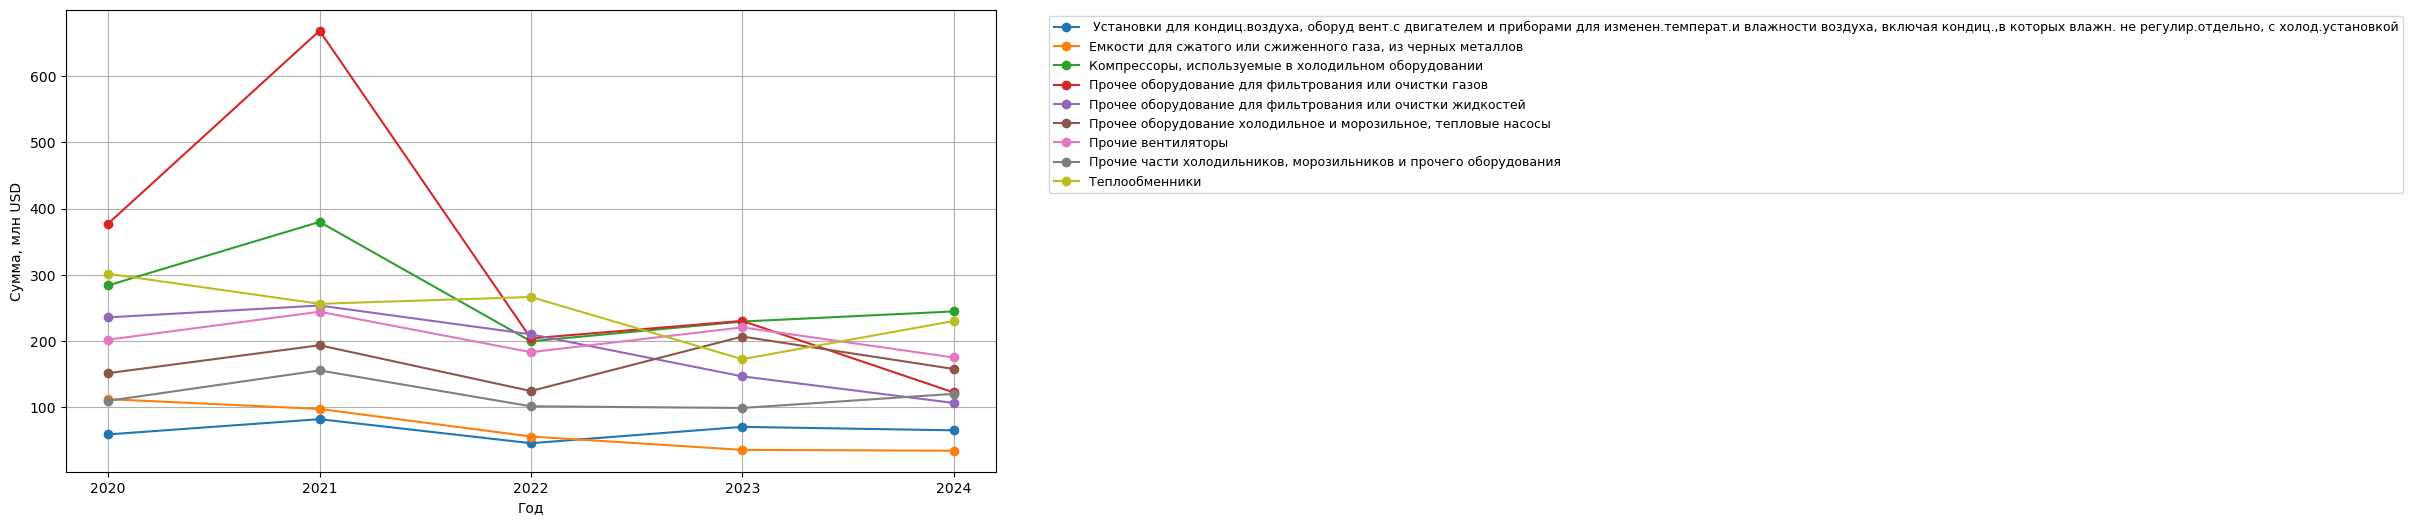

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df_import['import_value'] = df_import['fobvalue'].fillna(df_import['cifvalue'])

imp_grouped = (
    df_import.groupby(['refYear', 'cmdDesc'])['import_value']
    .sum()
    .unstack(fill_value=0) / 1000000
)
imp_grouped.index = imp_grouped.index.astype(int)

plt.figure(figsize=(12, 6))
for column in imp_grouped.columns:
    plt.plot(
        imp_grouped.index, imp_grouped[column],
        marker='o', label=column
    )

plt.xlabel('Год')
plt.ylabel('Сумма, млн USD')
plt.xticks(imp_grouped.index)
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', fontsize=9)
plt.grid(True)

ax = plt.gca()
plt.tight_layout()
plt.savefig(r'C:\Users\Qawse\Desktop\Кайрос\Рисунки\M_dinamics_usd.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
import_by_year_cat = df_import.groupby(['refYear', 'cmdDesc'])['fobvalue'].sum().unstack().fillna(0)
import_by_year_cat_transposed = import_by_year_cat.T
import_by_year_cat_bln = import_by_year_cat_transposed / 1e6

import_by_year_cat_bln.columns.name = 'Год'
import_by_year_cat_bln.index.name = 'Категория'

# Добавляем столбец с изменением за период в процентах
import_by_year_cat_bln['Изменение за период, %'] = ((import_by_year_cat_bln[2024] - import_by_year_cat_bln[2020]) / import_by_year_cat_bln[2020] * 100).round(1)

display(import_by_year_cat_bln.style.format("{:.2f}"))

Год,2020,2021,2022,2023,2024,"Изменение за период, %"
Категория,,,,,,
"Установки для кондиц.воздуха, оборуд вент.с двигателем и приборами для изменен.температ.и влажности воздуха, включая кондиц.,в которых влажн. не регулир.отдельно, с холод.установкой",59.40,82.37,46.13,70.78,65.54,10.30
"Емкости для сжатого или сжиженного газа, из черных металлов",112.60,97.78,56.24,36.06,34.79,-69.10
"Компрессоры, используемые в холодильном оборудовании",284.15,379.91,199.83,229.64,244.91,-13.80
Прочее оборудование для фильтрования или очистки газов,377.37,668.29,204.21,230.63,122.73,-67.50
Прочее оборудование для фильтрования или очистки жидкостей,235.95,253.80,210.36,146.96,106.86,-54.70
"Прочее оборудование холодильное и морозильное, тепловые насосы",151.83,193.87,124.84,206.98,158.11,4.10
Прочие вентиляторы,202.29,244.44,183.45,220.85,175.42,-13.30
"Прочие части холодильников, морозильников и прочего оборудования",110.10,155.92,101.79,99.26,120.56,9.50
Теплообменники,301.62,256.39,266.67,172.85,230.44,-23.60


#### Экспорт, в деньгах

In [32]:
export_by_year_cat = df_export.groupby(['refYear', 'cmdDesc'])['cifvalue'].sum().unstack().fillna(0)
export_by_year_cat_transposed = export_by_year_cat.T
export_by_year_cat_bln = export_by_year_cat_transposed / 1e6

export_by_year_cat_bln.columns.name = 'Год'
export_by_year_cat_bln.index.name = 'Категория'

# Добавляем столбец с изменением за период в процентах
export_by_year_cat_bln['Изменение за период, %'] = ((export_by_year_cat_bln[2024] - export_by_year_cat_bln[2020]) / export_by_year_cat_bln[2020] * 100).round(1)

display(export_by_year_cat_bln.style.format("{:.2f}"))

Год,2020,2021,2022,2023,2024,"Изменение за период, %"
Категория,,,,,,
"Установки для кондиц.воздуха, оборуд вент.с двигателем и приборами для изменен.температ.и влажности воздуха, включая кондиц.,в которых влажн. не регулир.отдельно, с холод.установкой",2.71,2.15,0.98,16.25,6.71,147.10
"Емкости для сжатого или сжиженного газа, из черных металлов",33.25,15.72,11.31,9.50,4.64,-86.10
"Компрессоры, используемые в холодильном оборудовании",8.21,9.58,5.53,3.20,0.38,-95.40
Прочее оборудование для фильтрования или очистки газов,67.44,71.86,56.09,49.75,41.30,-38.80
Прочее оборудование для фильтрования или очистки жидкостей,18.45,17.64,8.17,12.19,30.71,66.50
"Прочее оборудование холодильное и морозильное, тепловые насосы",30.94,34.79,23.26,17.09,19.00,-38.60
Прочие вентиляторы,30.36,42.27,30.88,33.29,6.12,-79.80
"Прочие части холодильников, морозильников и прочего оборудования",10.86,20.75,11.04,3.66,3.80,-65.00
Теплообменники,62.83,75.79,71.83,229.98,184.11,193.00


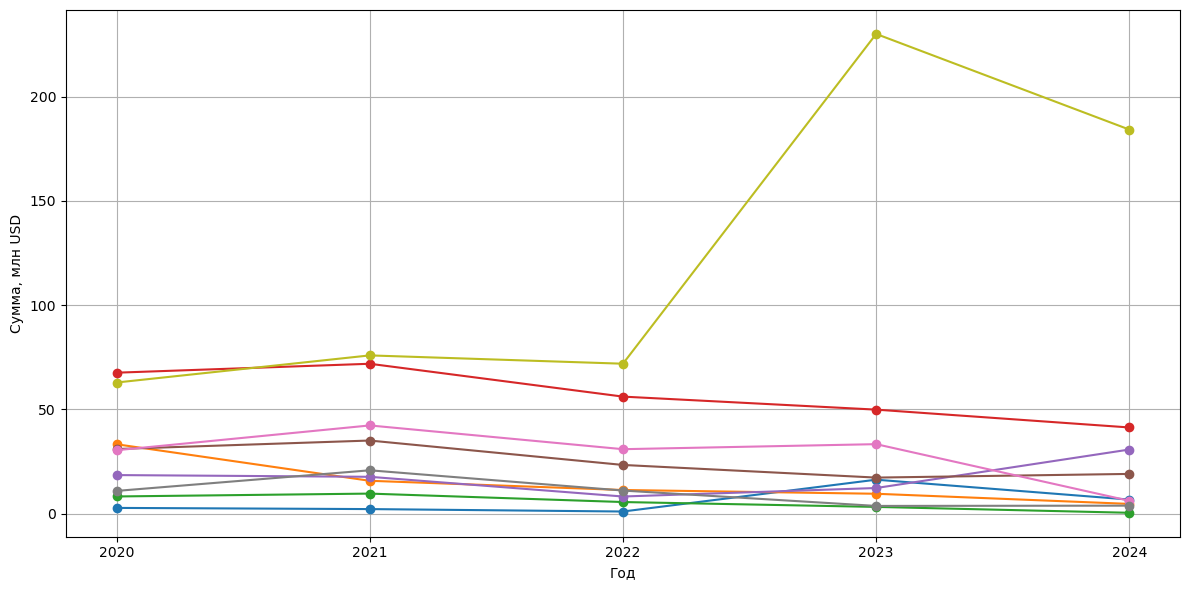

In [33]:
import matplotlib.ticker as ticker

df_export['export_value'] = df_export['cifvalue'].fillna(df_export['fobvalue'])

imp_grouped = (
    df_export.groupby(['refYear', 'cmdDesc'])['export_value']
    .sum()
    .unstack(fill_value=0) / 1000000
)
imp_grouped.index = imp_grouped.index.astype(int)

plt.figure(figsize=(12, 6))
for column in imp_grouped.columns:
    plt.plot(
        imp_grouped.index, imp_grouped[column],
        marker='o', label=column
    )

plt.xlabel('Год')
plt.ylabel('Сумма, млн USD')
plt.xticks(imp_grouped.index)
plt.grid(True)

ax = plt.gca()
plt.tight_layout()
plt.savefig(r'C:\Users\Qawse\Desktop\Кайрос\Рисунки\X_dinamics_usd.png', dpi=300, bbox_inches='tight')
plt.show()

#### Import net weight through years

C:\Users\Qawse\AppData\Local\Temp\ipykernel_29884\1292219534.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


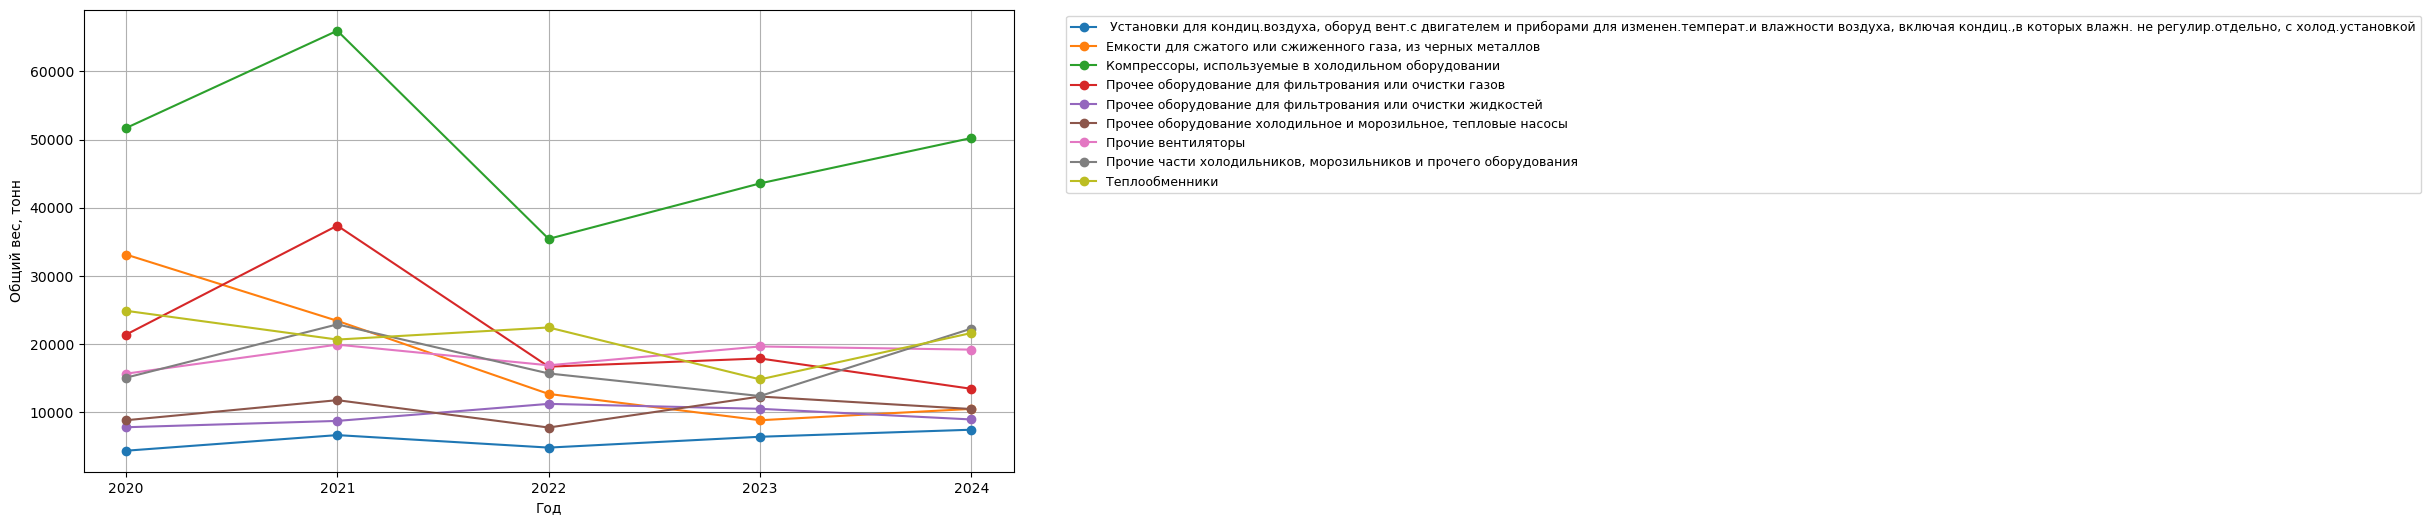

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df_import['refYear'] = df_import['refYear'].astype(int)
netweight_grouped = (
    df_import.groupby(['refYear', 'cmdDesc'])['netWgt']
    .sum()
    .unstack(fill_value=0) / 1000
)

plt.figure(figsize=(12, 6))
for column in netweight_grouped.columns:
    plt.plot(
        netweight_grouped.index,
        netweight_grouped[column],
        marker='o',
        label=column
    )

plt.xlabel('Год')
plt.ylabel('Общий вес, тонн')
plt.xticks(netweight_grouped.index)
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='best', fontsize=9)

plt.tight_layout()
plt.savefig(r'C:\Users\Qawse\Desktop\Кайрос\Рисунки\M_dinamics_netweight.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
netweight_grouped = netweight_grouped.T
netweight_grouped.columns.name = 'Год'
netweight_grouped.index.name = 'Категория'
netweight_grouped

Год,2020,2021,2022,2023,2024
Категория,,,,,
"Установки для кондиц.воздуха, оборуд вент.с двигателем и приборами для изменен.температ.и влажности воздуха, включая кондиц.,в которых влажн. не регулир.отдельно, с холод.установкой",4302.370822,6596.040915,4761.828484,6352.077639,7387.241023
"Емкости для сжатого или сжиженного газа, из черных металлов",33120.662076,23378.978863,12642.271485,8779.827748,10446.414927
"Компрессоры, используемые в холодильном оборудовании",51687.077131,65986.833164,35414.876157,43564.498768,50230.432406
Прочее оборудование для фильтрования или очистки газов,21346.629027,37358.250668,16646.185152,17854.408933,13394.518751
Прочее оборудование для фильтрования или очистки жидкостей,7749.867093,8680.350558,11183.428008,10457.335107,8893.076483
"Прочее оборудование холодильное и морозильное, тепловые насосы",8778.912922,11727.416894,7708.270397,12260.330375,10426.047090
Прочие вентиляторы,15614.874062,19885.962001,16847.556751,19614.804843,19149.427053
"Прочие части холодильников, морозильников и прочего оборудования",15024.495073,22857.144355,15650.200207,12333.146072,22236.935130
Теплообменники,24854.497945,20629.601973,22402.917726,14779.551014,21591.762270


#### Export net weight through years

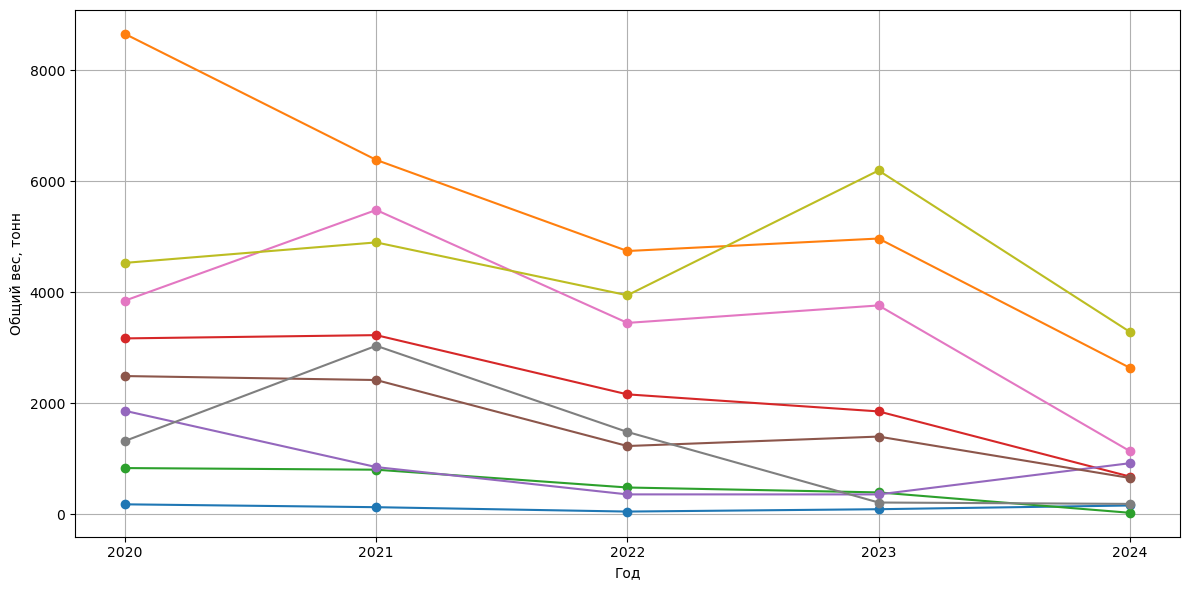

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

df_export['refYear'] = df_export['refYear'].astype(int)

netweight_grouped = (
    df_export.groupby(['refYear', 'cmdDesc'])['netWgt']
    .sum()
    .unstack(fill_value=0) / 1000
)

plt.figure(figsize=(12, 6))
for column in netweight_grouped.columns:
    plt.plot(
        netweight_grouped.index,
        netweight_grouped[column],
        marker='o',
        label=column
    )

plt.xlabel('Год')
plt.ylabel('Общий вес, тонн')
plt.xticks(netweight_grouped.index)
plt.grid(True)

plt.tight_layout()
plt.savefig(r'C:\Users\Qawse\Desktop\Кайрос\Рисунки\X_dinamics_netweight.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
netweight_grouped = netweight_grouped.T
netweight_grouped.columns.name = 'Год'
netweight_grouped.index.name = 'Категория'
netweight_grouped

Год,2020,2021,2022,2023,2024
Категория,,,,,
"Установки для кондиц.воздуха, оборуд вент.с двигателем и приборами для изменен.температ.и влажности воздуха, включая кондиц.,в которых влажн. не регулир.отдельно, с холод.установкой",179.984473,128.355687,49.607167,91.914308,159.049893
"Емкости для сжатого или сжиженного газа, из черных металлов",8653.919810,6384.688834,4743.337065,4968.184294,2640.328937
"Компрессоры, используемые в холодильном оборудовании",833.187667,803.953720,483.118945,394.773545,27.658587
Прочее оборудование для фильтрования или очистки газов,3169.146471,3228.054413,2160.987944,1853.903853,681.089162
Прочее оборудование для фильтрования или очистки жидкостей,1864.351284,851.129535,358.937143,358.456805,920.505064
"Прочее оборудование холодильное и морозильное, тепловые насосы",2490.739937,2419.255336,1230.404535,1400.481191,655.338901
Прочие вентиляторы,3849.799082,5482.690406,3448.175596,3762.811151,1139.916583
"Прочие части холодильников, морозильников и прочего оборудования",1321.739059,3036.222505,1483.627405,212.596491,187.658999
Теплообменники,4529.848340,4898.464837,3946.332522,6193.877566,3287.690749


In [48]:
import numpy as np
def calculate_uu(row):
    if row['qtyUnitAbbr'] == 'u':
        return row['qty']
    elif row['altQtyUnitAbbr'] == 'u':
        return row['altQty']
    else:
        return np.nan

df_import['uu'] = df_import.apply(calculate_uu, axis=1)
df_import = df_import.reset_index(drop=True)

def fill_uu_per_year_code(group):
    known_uu = group[group['uu'].notnull() & (group['uu'] > 0)]
    if known_uu.empty:
        return group
    avg_weight = (known_uu['netWgt'] / known_uu['uu']).mean()
    mask_missing = group['uu'].isnull() | (group['uu'] == 0)
    group.loc[mask_missing, 'uu'] = group.loc[mask_missing, 'netWgt'] / avg_weight
    return group

df_valid = df_import[(df_import['uu'] > 0) & (df_import['netWgt'] > 0)].copy()

grouped_data = df_valid.groupby('cmdDesc').agg(
    total_netWgt=('netWgt', 'sum'),
    total_uu=('uu', 'sum')
)
average_weight_per_unit = (grouped_data['total_netWgt'] / grouped_data['total_uu']).round(2)
average_weight_per_unit.index.name = 'Категория'
average_weight_per_unit

Категория
 Установки для кондиц.воздуха, оборуд вент.с двигателем и приборами для изменен.температ.и влажности воздуха, включая кондиц.,в которых влажн. не регулир.отдельно, с холод.установкой     36.44
Емкости для сжатого или сжиженного газа, из черных металлов                                                                                                                                 0.96
Компрессоры, используемые в холодильном оборудовании                                                                                                                                        8.01
Прочее оборудование для фильтрования или очистки газов                                                                                                                                      1.81
Прочее оборудование для фильтрования или очистки жидкостей                                                                                                                                  0.80
Прочее оборудование холод

### Цена импортированной продукции за рассчитанную единицу товара

In [49]:
import pandas as pd
import numpy as np

df_valid_units = df_import[(df_import['uu'] > 0) & (df_import['import_value'] > 0)].copy()
df_valid_units['price_per_unit'] = df_valid_units['import_value'] / df_valid_units['uu']

price_per_unit_table = (
    df_valid_units.groupby(['refYear', 'cmdCode'])['price_per_unit']
                  .mean()
                  .unstack(fill_value=np.nan)
)

price_per_unit_table.columns.name = 'Код ТН ВЭД'
price_per_unit_table.index.name = 'Год'

price_per_unit_table

Код ТН ВЭД,731100,841430,841459,841582,841869,841899,841950,842129,842139,848180
Год,,,,,,,,,,
2020,61.544741,1817.944351,480.888431,3695.392910,5831.543416,NaN,24344.468199,249.138102,1355.557844,216.297680
2021,1401.764821,4450.951242,218.096298,4528.882727,8713.343726,NaN,12087.374900,5558.321447,117.844433,1919.930029
2022,880.123303,1673.256557,523.569081,10198.000467,5337.610673,NaN,9632.947512,100.843807,223.668534,1363.082232
2023,369.162275,1235.663901,25833.395656,2337.792312,48744.200533,15143.0,167080.264452,50.961125,264.690807,31.377989
2024,1107.270187,6722.643517,821.249952,4206.183442,1056.361474,NaN,123753.065020,199.634119,366.729101,65.646681


### Price per net weight (kg)

#### Import

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for column in price_per_kg_table.columns:
    plt.plot(
        price_per_kg_table.index,
        price_per_kg_table[column],
        marker='o',
        label=column
    )

plt.xlabel('Год')
plt.ylabel('Цена за кг, USD')
plt.xticks(price_per_kg_table.index)
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig(r'C:\Users\Qawse\Desktop\Кайрос\Рисунки\M_price_per_kg.png', dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'price_per_kg_table' is not defined

<Figure size 1200x600 with 0 Axes>

In [51]:
import pandas as pd
import numpy as np

df_valid_kg = df_import[(df_import['netWgt'] > 0) & (df_import['import_value'] > 0)].copy()
df_valid_kg['price_per_kg'] = df_valid_kg['import_value'] / df_valid_kg['netWgt']

price_per_kg_table = (
    df_valid_kg.groupby(['refYear', 'cmdDesc'])['price_per_kg']
               .mean()
               .unstack(fill_value=np.nan)
)
price_per_kg_table.columns.name = 'Год'
price_per_kg_table.index.name = 'Категория'
price_per_kg_table.T

Категория,2020,2021,2022,2023,2024
Год,,,,,
"Установки для кондиц.воздуха, оборуд вент.с двигателем и приборами для изменен.температ.и влажности воздуха, включая кондиц.,в которых влажн. не регулир.отдельно, с холод.установкой",51.279204,34.072208,23.263715,33.666923,32.956280
"Емкости для сжатого или сжиженного газа, из черных металлов",19.998791,30.515241,35.934080,92.911314,44.289365
"Компрессоры, используемые в холодильном оборудовании",14.591849,17.858188,17.389039,23.465075,651.042569
Прочее оборудование для фильтрования или очистки газов,28.479420,46.012952,40.837231,79.750935,89.317774
Прочее оборудование для фильтрования или очистки жидкостей,131.747844,50.133729,105.120303,63.968436,98.313968
"Прочее оборудование холодильное и морозильное, тепловые насосы",26.563581,60.476466,29.281231,80.040168,37.568817
Прочие вентиляторы,21.292413,20.696257,28.034473,54.003855,35.640676
"Прочие части холодильников, морозильников и прочего оборудования",35.353915,45.280630,43.628869,64.954143,87.571806
Теплообменники,25.969328,29.922306,42.020863,238.160795,905.052070


#### Export

In [52]:
plt.figure(figsize=(12, 6))
for column in price_grouped.columns:
    plt.plot(
        price_grouped.index,
        price_grouped[column],
        marker='o',
        label=column
    )

plt.xlabel('Год')
plt.ylabel('Цена за кг, USD')
plt.xticks(price_grouped.index)
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig(r'C:\Users\Qawse\Desktop\Кайрос\Рисунки\X_price_per_kg.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'price_grouped' is not defined

<Figure size 1200x600 with 0 Axes>

In [53]:
df_export['export_value'] = df_export['cifvalue'].fillna(df_import['fobvalue'])
df_valid = df_export[(df_export['netWgt'] > 0) & (df_export['export_value'] > 0)].copy()

df_valid['price_per_kg'] = df_valid['export_value'] / df_valid['netWgt']

price_grouped = (
    df_valid.groupby(['refYear', 'cmdDesc'])['price_per_kg']
    .mean()
    .unstack(fill_value=0)
)
price_grouped.columns.name = 'Год'
price_grouped.index.name = 'Категория'
price_grouped.T

Категория,2020,2021,2022,2023,2024
Год,,,,,
"Установки для кондиц.воздуха, оборуд вент.с двигателем и приборами для изменен.температ.и влажности воздуха, включая кондиц.,в которых влажн. не регулир.отдельно, с холод.установкой",23.684478,55.240063,18.513675,135.763602,148.027887
"Емкости для сжатого или сжиженного газа, из черных металлов",22.378285,226.764603,6.353115,7.861425,5.542095
"Компрессоры, используемые в холодильном оборудовании",70.911908,24.923514,11.415434,11.793486,27.692215
Прочее оборудование для фильтрования или очистки газов,5487.613104,709.128324,47.629108,456.712600,56.894780
Прочее оборудование для фильтрования или очистки жидкостей,46.437215,15603.749913,62.466034,405.134488,161.144605
"Прочее оборудование холодильное и морозильное, тепловые насосы",157.805466,303.859231,662.808128,511.640637,265.921308
Прочие вентиляторы,157.171933,74.886034,24.697804,399.519048,46.541448
"Прочие части холодильников, морозильников и прочего оборудования",161.832519,157.611148,217.891228,562.250240,777.361711
Теплообменники,131.443673,147.201272,127.579222,104.755760,32.653285


### Price changes на теплообменники по странам

In [54]:
codes = [841950]
df_valid = df_valid[df_valid['cmdCode'].isin(codes)]

country_price = (
    df_valid.groupby(['refYear', 'reporterDesc'])['price_per_kg']
    .mean()
    .unstack()
    .transpose()
)

country_price_filtered = country_price.dropna(subset=[2020, 2024])

top_increasers = country_price_filtered.sort_values(2024, ascending=False)
top_increasers.columns.name = 'Страна/Год'
top_increasers

Страна/Год,2020,2021,2022,2023,2024
reporterDesc,,,,,
Serbia,14.515152,7.749937,26.627586,NaN,113.461194
China,127.617410,286.956522,46.936325,57.967131,59.903981
Argentina,21.381191,NaN,NaN,NaN,53.180000
Rep. of Korea,16.857098,NaN,26.536310,NaN,52.710769
Rep. of Moldova,9.918305,41.283196,9.530216,53.888889,39.062500
Azerbaijan,6.798392,5.507497,10.891836,14.077287,31.641863
Türkiye,36.007720,29.169508,21.035878,20.032329,25.641318
Egypt,19.007930,19.798349,NaN,24.713524,24.485736
USA,19.007961,19.400843,20.327449,23.594381,24.485704


#### Куда Россия экспортирует продукцию?

In [59]:
df_exp_2024 = df_export[df_export['refYear'] == 2024]

exp_by_country = (
    df_exp_2024.groupby('reporterDesc')['export_value']
    .sum()
    .sort_values(ascending=False)
)

total_export = exp_by_country.sum()

export_table = pd.DataFrame({
    '$ тыс': (exp_by_country / 1_000).round(2),
    'Доля в общем, %': (exp_by_country / total_export * 100).round(1)
})

export_table = export_table.reset_index().rename(columns={'reporterDesc': 'Страна'})

export_table

,Страна,$ тыс,"Доля в общем, %"
0,China,252431.64,54.5
1,Türkiye,124298.94,26.8
2,Uzbekistan,47251.61,10.2
3,Armenia,9573.26,2.1
4,Azerbaijan,6283.58,1.4
5,Egypt,5281.82,1.1
6,Kyrgyzstan,5166.79,1.1
7,Rep. of Korea,5130.98,1.1
8,USA,2194.45,0.5
9,Georgia,2174.80,0.5


#### Откуда Россия импортирует оборудование?

In [60]:
df_imp_2024 = df_import[df_import['refYear'] == 2024]

imp_by_country = (
    df_imp_2024.groupby('reporterDesc')['import_value']
    .sum()
    .sort_values(ascending=False)
)

total_import = imp_by_country.sum()

import_table = pd.DataFrame({
    '$ тыс': (imp_by_country / 1_000).round(2),
    'Доля в общем, %': (imp_by_country / total_import * 100).round(1)
})

import_table = import_table.reset_index().rename(columns={'reporterDesc': 'Страна'})

import_table

,Страна,$ тыс,"Доля в общем, %"
0,China,2062478.73,76.0
1,Türkiye,152460.59,5.6
2,Italy,147546.62,5.4
3,Rep. of Korea,66283.34,2.4
4,Germany,45489.03,1.7
5,India,41857.88,1.5
6,Malaysia,29086.14,1.1
7,Slovakia,18839.94,0.7
8,Poland,15780.46,0.6
9,Czechia,12581.55,0.5


#### Доли рынка

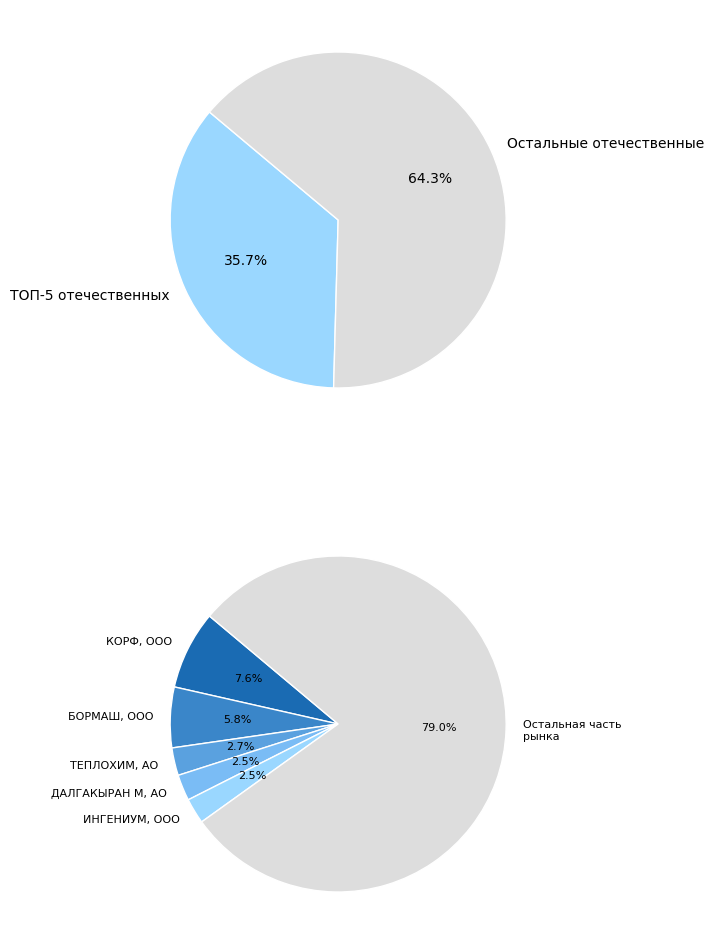

In [63]:
import matplotlib.pyplot as plt

def market_share_full_analysis(df, production, import_value_cif, export_value_fob):
    top_5 = df.nlargest(5, 'revenue_2024')
    domestic_total = df['revenue_2024'].sum()
    top5_domestic = top_5['revenue_2024'].sum()
    rest_domestic = domestic_total - top5_domestic
    
    supply_no_export = production + import_value_cif
    domestic_share = production
    import_share = import_value_cif
    
    market_total = production + import_value_cif - export_value_fob
    top5_market = top5_domestic
    rest_market = market_total - top5_market
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    ax1, ax2 = axes.flatten()
    
    # График 1: Топ‑5 vs остальные отечественные
    ax1.pie(
        [top5_domestic, rest_domestic],
        labels=['ТОП‑5 отечественных', 'Остальные отечественные'],
        colors=['#9ad7ff', '#dddddd'],
        autopct='%1.1f%%', startangle=140,
        wedgeprops={'linewidth':1,'edgecolor':'white'},
        textprops={'fontsize':10}
    )
    
    # График 4: Детализация ТОП‑5 vs остальная часть рынка
    sizes_market = top_5['revenue_2024'].tolist() + [rest_market]
    labels_market = top_5['name'].tolist() + ['Остальная часть\nрынка']
    colors_market = ['#1a6bb3', '#3a86c9', '#5aa1df', '#7abcf5', '#9ad7ff', '#dddddd']
    ax2.pie(
        sizes_market, labels=labels_market, colors=colors_market,
        autopct='%1.1f%%', startangle=140,
        wedgeprops={'linewidth':1,'edgecolor':'white'},
        textprops={'fontsize':8}
    )
    
production = 67_231_169_000
import_value_cif = 71_920_870_231.70
export_value_fob = 21_269_718_325.33
market_share_full_analysis(df, production, import_value_cif, export_value_fob)


In [67]:
top20 = production.head(20)
print("\nТоп-20 отечественных производителей:")
display(top20[['name', 'revenue_2024']].style.format({'revenue_2024': '{:,.0f}'}))

AttributeError: 'int' object has no attribute 'head'

### Кодирование регионов

In [26]:
import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster
import pandas as pd
import folium
from folium.plugins import HeatMap
from ast import literal_eval

df = pd.read_excel(r"C:\Users\Qawse\Desktop\Кайрос\Предложение\production_with_coords.xlsx")

df['coords'] = df['coords'].apply(lambda x: literal_eval(x) if pd.notna(x) and x.startswith('(') else None)

# Создаем базовую карту с центром в России
m = folium.Map(location=[60, 90], zoom_start=4, tiles='CartoDB positron')

# Добавляем тепловую карту для визуализации плотности контрактов
heat_data = [[coord[0], coord[1]] for coord in df['coords'].dropna() if len(coord) == 2]
HeatMap(heat_data, radius=15).add_to(m)

# Добавляем маркеры для каждого контракта
marker_cluster = folium.plugins.MarkerCluster().add_to(m)

for idx, row in df.dropna(subset=['coords']).iterrows():
    folium.Marker(
        location=row['coords'],
        popup=folium.Popup(
            f"<b>Название:</b> {row['name'][:100]}...<br>"
            f"<b>Выручка:</b> {row['revenue_2024']}<br>"
            f"<b>Адрес:</b> {row['adress']}",
            max_width=300
        ),
        icon=None
    ).add_to(marker_cluster)

# Добавляем слой для переключения между видами
folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.LayerControl().add_to(m)

map_path = r"C:\Users\Qawse\Desktop\Кайрос\Предложение\simple_production_map.html"
m.save(map_path)
print(f"Карта успешно сохранена: {map_path}")

Карта успешно сохранена: C:\Users\Qawse\Desktop\Кайрос\Предложение\simple_production_map.html


Bank for International Settlements (2025), Bilateral exchange rates, BIS WS_XRU 1.0 (data set), https://data.bis.org/topics/XRU/data (accessed on 28 September 2025).

In [49]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import statsmodels.formula.api as smf
import statsmodels.api as sm

# === ПУТИ ===
PATH_COORDS = r"C:\Users\Qawse\Desktop\Кайрос\Предложение\Импорт\coord_countries.xlsx"
PATH_GDP = r"C:\Users\Qawse\Desktop\Кайрос\Предложение\Импорт\gdp_data.xls"
PATH_FX = r"C:\Users\Qawse\Desktop\Кайрос\Предложение\Импорт\currencies vs usd.xlsx"
PATH_LPI = r"C:\Users\Qawse\Desktop\Кайрос\Предложение\Импорт\International_LPI_from_2007_to_2023_0.xlsx"

# === 1. Загружаем файлы (коротко) ===
coords = pd.read_excel(PATH_COORDS)
gdp = pd.read_excel(PATH_GDP)
fx = pd.read_excel(PATH_FX, sheet_name="timeseries observations")
lpi = pd.read_excel(PATH_LPI)

# === 2. Чистим coords: приведём широты/долготы к числам и посмотрим первые строки ===
coords.columns = coords.columns.str.strip()
# Попробуем несколько вариантов имён колонок
for c in ['name','Name','country','Country']:
    if c in coords.columns:
        coords = coords.rename(columns={c: 'name'})
        break
for c in ['latitude','Latitude','lat','Lat']:
    if c in coords.columns:
        coords = coords.rename(columns={c: 'latitude'})
        break
for c in ['longitude','Longitude','lon','Lon','lng']:
    if c in coords.columns:
        coords = coords.rename(columns={c: 'longitude'})
        break

coords['latitude'] = pd.to_numeric(coords['latitude'], errors='coerce')
coords['longitude'] = pd.to_numeric(coords['longitude'], errors='coerce')

print("Coords sample:\n", coords[['name','latitude','longitude']].head())
print("Coords dtypes:\n", coords[['latitude','longitude']].dtypes)

# === 3. Чистим FX и LPI ===
fx = fx.rename(columns={"Reference area":"reporterDesc", "Period":"refYear", "Value":"fx_usd"})
fx['refYear'] = pd.to_datetime(fx['refYear'], errors='coerce').dt.year
fx = fx[['reporterDesc','refYear','fx_usd']].dropna(subset=['reporterDesc','refYear','fx_usd'])
fx['fx_usd'] = fx['fx_usd'].astype(str).str.replace(',','.', regex=False)
fx['fx_usd'] = pd.to_numeric(fx['fx_usd'], errors='coerce')
fx = fx[fx['fx_usd'] > 0].copy()
fx['ln_fx'] = np.log(fx['fx_usd'])

lpi.columns = lpi.columns.str.strip()
lpi = lpi.rename(columns={"Economy":"reporterDesc","LPI Score":"lpi"})
if 'lpi' not in lpi.columns:
    # если столбец называется иначе, покажем колонки
    print("LPI columns:", lpi.columns.tolist())
lpi['reporterDesc'] = lpi['reporterDesc'].astype(str).str.strip()

# === 4. Чистим торговый датасет (df_import должен быть в окружении) ===
df = df_import.copy()
# стандартные маппинги (подправь, если у тебя другие названия)
country_map = {
    'Bosnia Herzegovina': 'Bosnia and Herzegovina',
    'China, Hong Kong SAR': 'Hong Kong',
    'Czechia': 'Czech Republic',
    'Rep. of Korea': 'South Korea',
    'Türkiye': 'Turkey',
    'USA': 'United States',
    'Viet Nam': 'Vietnam'
}
df['reporterDesc'] = df['reporterDesc'].replace(country_map)
df = df[df['reporterDesc'] != 'Other Asia, nes']

print("Unique reporters sample:", list(df['reporterDesc'].unique())[:10])

# === 5. GDP: melt и merge ===
gdp_melt = gdp.melt(id_vars=['Country Code'], value_vars=['2020','2021','2022','2023','2024'],
                    var_name='refYear', value_name='gdp')
gdp_melt['refYear'] = gdp_melt['refYear'].astype(int)
gdp_melt = gdp_melt.rename(columns={'Country Code':'reporterISO'})
df = df.merge(gdp_melt, on=['reporterISO','refYear'], how='left')

# === 6. Merge координат и защищённый расчёт расстояния ===
df = df.merge(coords[['name','latitude','longitude']], left_on='reporterDesc', right_on='name', how='left')

def safe_distance(lat, lon):
    try:
        if pd.isna(lat) or pd.isna(lon):
            return np.nan
        return geodesic((61.52401,105.318756), (float(lat), float(lon))).km
    except Exception as e:
        return np.nan

df['distance_km'] = df.apply(lambda r: safe_distance(r['latitude'], r['longitude']), axis=1)

# покажем, у каких стран нет координат
missing_coords = pd.Series(df.loc[df['distance_km'].isna(), 'reporterDesc'].unique())
print("Countries with missing coords (sample):", missing_coords.head(20).tolist())

# === 7. Логарифмы и зависимая переменная (проверки) ===
df['trade_val'] = df['primaryValue'].fillna(0)
df.loc[df['trade_val'] < 0, 'trade_val'] = 0

print("trade_val describe:\n", df['trade_val'].describe())
print("fraction zeros:", (df['trade_val']==0).mean())
print("max trade_val:", df['trade_val'].max())

# Если max очень большой, лучше масштабировать для числовой устойчивости
SCALE = 1.0
if df['trade_val'].max() > 1e9:
    SCALE = 1e6
    print("Scaling trade_val by 1e6 to improve numerical stability")
    df['trade_scaled'] = df['trade_val'] / SCALE
else:
    df['trade_scaled'] = df['trade_val']

# логарифмы регрессоров
df['ln_gdp'] = np.log(df['gdp'].fillna(0) + 1)
df['ln_distance'] = np.log(df['distance_km'].fillna(0) + 1)

# === 8. Присоединяем FX и LPI (если нужны) ===
df = df.merge(fx[['reporterDesc','refYear','fx_usd','ln_fx']],
              on=['reporterDesc','refYear'], how='left')
df = df.merge(lpi[['reporterDesc','lpi']], on='reporterDesc', how='left')

# === 9. Отфильтруем для моделей (уберём явные пропуски) ===
df_model = df.dropna(subset=['trade_scaled','ln_gdp','ln_distance']).copy()
print("Observations for models:", len(df_model))

# === 10. OLS диагностика (лог суммы) ===
ols = smf.ols("np.log1p(trade_scaled) ~ ln_gdp + ln_distance + C(refYear)", data=df_model).fit()
print(ols.summary())

# === 11. PPML (Poisson Pseudo-Maximum Likelihood) ===
# используем trade_scaled (можно заменить на trade_val — но масштаб может влиять на численность ll)
ppml = smf.glm("trade_scaled ~ ln_gdp + ln_distance + C(refYear)", data=df_model,
               family=sm.families.Poisson()).fit(cov_type="cluster", cov_kwds={"groups": df_model["reporterDesc"]})
print(ppml.summary())

# === 12. Диагностика PPML вручную ===
ys = df_model['trade_scaled'].values
mu = ppml.predict(df_model)
n = len(df_model)
pearson_chi2 = np.sum((ys - mu)**2 / (mu + 1e-9))
dispersion = pearson_chi2 / ppml.df_resid
print("Pearson chi2:", pearson_chi2)
print("Dispersion (Pearson chi2 / df_resid):", dispersion)
# Cox-Snell and McFadden pseudo-R2 (compute null model for comparison)
null = smf.glm("trade_scaled ~ 1", data=df_model, family=sm.families.Poisson()).fit()
LL_full = ppml.llf
LL_null = null.llf
cs = 1 - np.exp((LL_null - LL_full) * 2 / n)
mcf = 1 - LL_full / LL_null if LL_null != 0 else np.nan
print("LL_full:", LL_full, "LL_null:", LL_null)
print("Cox-Snell R2:", cs)
print("McFadden R2:", mcf)

# === 13. Корреляции между регрессорами (быстрая проверка мультиколлинеарности) ===
print("corr matrix:\n", df_model[['ln_gdp','ln_distance','ln_fx','lpi']].corr())

Coords sample:
                    name   latitude  longitude
0               Andorra  42.546245   1.601554
1  United Arab Emirates  23.424076  53.847818
2           Afghanistan  33.939110  67.709953
3   Antigua and Barbuda  17.060816 -61.796428
4              Anguilla  18.220554 -63.068615
Coords dtypes:
 latitude     float64
longitude    float64
dtype: object
Unique reporters sample: ['Azerbaijan', 'Austria', 'Armenia', 'Belgium', 'Bulgaria', 'Belarus', 'Brazil', 'Australia', 'Argentina', 'Angola']
Countries with missing coords (sample): ['Croatia', 'Rep. of Moldova', 'North Macedonia', 'Congo']
trade_val describe:
 count    2.055000e+03
mean     7.884011e+06
std      4.979557e+07
min      1.000000e+00
25%      3.713942e+04
50%      4.244578e+05
75%      3.033642e+06
max      1.145376e+09
Name: trade_val, dtype: float64
fraction zeros: 0.0
max trade_val: 1145375618.0
Scaling trade_val by 1e6 to improve numerical stability
Observations for models: 3884
                              OL

In [39]:
corr_matrix = df_ppml_clean[['trade_val', 'ln_gdp', 'ln_distance', 'ln_fx']].corr()
print(corr_matrix)

             trade_val    ln_gdp  ln_distance     ln_fx
trade_val     1.000000  0.213754    -0.161025 -0.028888
ln_gdp        0.213754  1.000000     0.192328 -0.140460
ln_distance  -0.161025  0.192328     1.000000 -0.223178
ln_fx        -0.028888 -0.140460    -0.223178  1.000000


In [50]:
df_model.to_csv(r"C:\Users\Qawse\Desktop\Кайрос\Предложение\Импорт\df_final_for_R.csv", index=False)

In [51]:
df_model.columns

Index(['typeCode', 'freqCode', 'refPeriodId', 'refYear', 'refMonth', 'period',
       'reporterCode', 'reporterISO', 'reporterDesc', 'flowCode',
       'partnerCode', 'partnerISO', 'partnerDesc', 'partner2Code',
       'partner2ISO', 'partner2Desc', 'classificationCode',
       'classificationSearchCode', 'isOriginalClassification', 'cmdCode',
       'cmdDesc', 'aggrLevel', 'isLeaf', 'customsCode', 'customsDesc',
       'mosCode', 'motCode', 'motDesc', 'qtyUnitCode', 'qtyUnitAbbr', 'qty',
       'isQtyEstimated', 'altQtyUnitCode', 'altQtyUnitAbbr', 'altQty',
       'isAltQtyEstimated', 'netWgt', 'isNetWgtEstimated', 'grossWgt',
       'isGrossWgtEstimated', 'cifvalue', 'fobvalue', 'primaryValue',
       'legacyEstimationFlag', 'isReported', 'isAggregate', 'gdp', 'name',
       'latitude', 'longitude', 'distance_km', 'trade_val', 'trade_scaled',
       'ln_gdp', 'ln_distance', 'fx_usd', 'ln_fx', 'lpi'],
      dtype='object')